In [1]:
from datasets.mnist import read_data
import numpy as np
from utils import *
import matplotlib.pyplot as plt

FIG_FOLDER = 'kpca/mnist'
SAVE_PLOTS = True # save all the plots
# SAVE_PLOTS = False # save all the plots
DTYPE = np.float32
wanted_freq = 1200 # number of samples per class
wanted_freq2 = 700 # number of samples per class for the training, rest for validation

# figure size
plt.rcParams["figure.figsize"] = (10,8)

# load the data
chose_split = False # load all the data and then chose how to split
if chose_split:
    X, y = read_data.load_all_data()

    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1337)
    del X # save some space
    del y # save some space
else:
    # load the training and testing sets as given by the author
    x_train, y_train = read_data.load_train_data()
    x_test, y_test = read_data.load_test_data()

# serialize images (from 2d to 1d)
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

# test = True # for testing stuff without the need to wait an eternity
test = False # for testing stuff without the need to wait an eternity
if test:
    wanted_freq = 400
    wanted_freq2 = 150
    # x_train = x_train[:2000]
    # y_train = y_train[:2000]
    x_test = x_test[:800]
    y_test = y_test[:800]

In [2]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train).astype(DTYPE)
x_test = scaler.transform(x_test).astype(DTYPE)

In [3]:
# subsample training data in order to equalize class frequencies
# we match the lowest class frequency
vals, freq = np.unique(y_train, return_counts = True)
# wanted_freq = min(freq)
all_indexes = np.zeros((len(freq), wanted_freq), dtype=np.uint32)
for i, v in enumerate(vals):
    indexes = np.random.choice(np.where(y_train == v)[0], size=wanted_freq, replace=False)
    all_indexes[i, :] = indexes
all_indexes = np.sort(all_indexes.flatten())
y_train = y_train[all_indexes]
x_train = x_train[all_indexes, :]

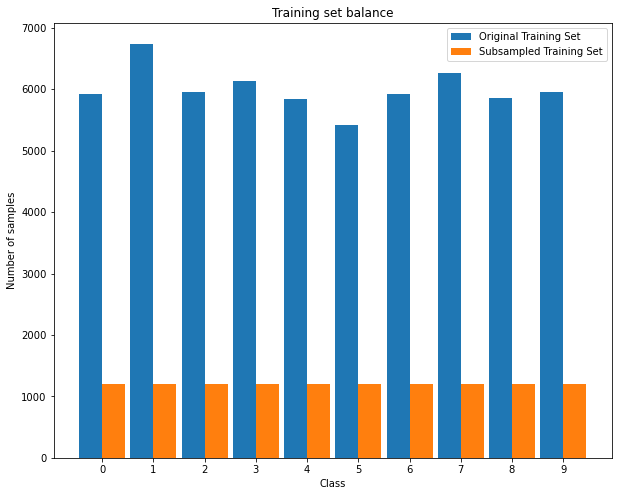

In [4]:
vals2, freq2 = np.unique(y_train, return_counts = True)
x_ = np.arange(len(freq))
width = 0.45

# fig, ax = plt.subplots(figsize=(15,12))
fig, ax = plt.subplots()
ax.bar(x_ - width/2, freq, width, label='Original Training Set')
ax.bar(x_ + width/2, freq2, width, label='Subsampled Training Set')
ax.set_ylabel('Number of samples')
ax.set_xlabel('Class')
ax.set_title('Training set balance')
ax.set_xticks(x_)
ax.set_xticklabels(vals)
ax.legend()
plt.show()
if SAVE_PLOTS:
    save_plots(fig, 'training_freq', FIG_FOLDER)

In [5]:
# hold wanted_freq2 samples per class for training and the rest of the
# training set for validation
x_train_all = x_train
y_train_all = y_train

all_indexes = np.zeros((len(freq), wanted_freq2), dtype=np.uint32)
for i, v in enumerate(vals):
    indexes = np.random.choice(np.where(y_train == v)[0], size=wanted_freq2, replace=False)
    all_indexes[i, :] = indexes
all_indexes = np.sort(all_indexes.flatten())
y_train = y_train_all[all_indexes]
x_train = x_train_all[all_indexes, :]
validation_indexes = np.delete(np.arange(y_train_all.shape[0]), all_indexes)
y_val = y_train_all[validation_indexes]
x_val = x_train_all[validation_indexes, :]

In [6]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((7000, 784), (7000,), (5000, 784), (5000,))

In [7]:
from kpca_plus_lda import KPCA_LDA


params = [
          {'kernel': 'linear'},
          {'kernel': 'poly', 'degree': 2, 'gamma': 0.1},
          {'kernel': 'poly', 'degree': 2, 'gamma': 1},
          {'kernel': 'poly', 'degree': 2, 'gamma': 10},

          # {'kernel': 'rbf', 'gamma': 0.001},
          # {'kernel': 'rbf', 'gamma': 0.005},
          # {'kernel': 'rbf', 'gamma': 0.01},
          {'kernel': 'rbf', 'gamma': 0.05},
          {'kernel': 'rbf', 'gamma': 0.1},
          {'kernel': 'rbf', 'gamma': 0.5},
          # {'kernel': 'rbf', 'gamma': 1},

          {'kernel': 'sigmoid', 'gamma': 0.00001},
          {'kernel': 'sigmoid', 'gamma': 0.0001},
          {'kernel': 'sigmoid', 'gamma': 0.001},
         ]

# models = [KPCA_LDA(**kwargs) for kwargs in params]

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from time import time

neighbors = [1, 3, 5, 10, 15]

times, metrics_knn, metrics_nc = [], [], []
for kwargs in params:
    t0 = time()
    model = KPCA_LDA(**kwargs)
    dist, z_train = model.fit(x_train, y_train, return_z=True)
    dist_val, z_val = model.transform(x_val, return_z=True)
    t1 = time()

    knn_metrics = []
    for n in neighbors:
        knn = KNeighborsClassifier(n_neighbors=n, metric='precomputed')
        knn.fit(dist, y_train)
        metrics = calculate_metrics(knn, dist_val, y_val)
        knn_metrics.append(metrics)
    t2 = time()

    nc = NearestCentroid()
    nc.fit(z_train, y_train)
    t3 = time()

    nc_val_metrics = calculate_metrics(nc, z_val, y_val)

    times.append((t0, t1, t2, t3))
    metrics_knn.append(knn_metrics)
    metrics_nc.append(nc_val_metrics)

    print(f'{model.kernel}: {metrics[0]:.4f} | {nc_val_metrics[0]:.4f}')
    print(f'KPCA+LDA: {t1-t0:.4f}, KNN: {t2-t1:.4f}, nc: {t3-t2:.4f}, total: {t3-t0:.4f}')

/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classifica

linear: 0.1000 | 0.1950
KPCA+LDA: 395.2417, KNN: 3.1450, nc: 0.0020, total: 398.3887


/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classifica

poly: 0.2330 | 0.9156
KPCA+LDA: 1935.2967, KNN: 4.1911, nc: 0.0027, total: 1939.4904


/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classifica

poly: 0.2758 | 0.7542
KPCA+LDA: 2312.4720, KNN: 3.8880, nc: 0.0030, total: 2316.3630


/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classifica

poly: 0.1000 | 0.1000
KPCA+LDA: 2300.3693, KNN: 2.9016, nc: 0.0027, total: 2303.2736
rbf: 0.9650 | 0.9292
KPCA+LDA: 1767.7612, KNN: 4.1797, nc: 0.0028, total: 1771.9436
rbf: 0.8762 | 0.6912
KPCA+LDA: 2117.4952, KNN: 4.0665, nc: 0.0026, total: 2121.5643
rbf: 0.2622 | 0.1526
KPCA+LDA: 2067.6769, KNN: 4.0359, nc: 0.0082, total: 2071.7210


/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classifica

sigmoid: 0.1000 | 0.1152
KPCA+LDA: 90.2835, KNN: 3.1306, nc: 0.0026, total: 93.4167


/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classifica

sigmoid: 0.1000 | 0.1278
KPCA+LDA: 78.8584, KNN: 3.1163, nc: 0.0026, total: 81.9773


/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classifica

sigmoid: 0.1060 | 0.1330
KPCA+LDA: 406.4696, KNN: 2.8461, nc: 0.0026, total: 409.3183


/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seiras/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
# save the results
import pandas as pd

save_folder = f'results/{FIG_FOLDER}/'
create_if_not_exists(save_folder)

# create the names for the models
names = []
for p in params:
    names.append("\n".join([f'{key}: {val}' for key, val in p.items()]))

kpca_lda_time = []
nc_times = []
for t in times:
    kpca_lda_time.append(t[1] - t[0])
    nc_times.append(t[3] - t[2])

# save nc data
data = zip(names, *(np.array(metrics_nc).T), kpca_lda_time, nc_times)
col_names = ["Model", "Accuracy", "Precision", "Recall", "F1", "KPCA+LDA Time (seconds)", "Nearest Centroid Time"]
df = pd.DataFrame(data, columns=col_names)
df.to_excel(save_folder+'nc_validation.xlsx', float_format="%.4f", index=False)
df.to_csv(save_folder+'nc_validation.csv', float_format="%.4f", index=False)

In [10]:
acc_knn = np.array([[n[0] for n in m] for m in metrics_knn])
best_idxes = np.argmax(acc_knn, axis=1)
best_n_knn = np.array(neighbors)[best_idxes]

# save knn data
data = zip(names, best_n_knn, *(np.array(metrics_knn)[np.arange(len(metrics_knn)), best_idxes].T))
col_names = ["Model", "Best n", "Accuracy", "Precision", "Recall", "F1"]
df = pd.DataFrame(data, columns=col_names)
df.to_excel(save_folder+'knn_validation.xlsx', float_format="%.4f", index=False)
df.to_csv(save_folder+'knn_validation.csv', float_format="%.4f", index=False)

In [11]:
for mm, m, p in zip(metrics_knn, metrics_nc, params):
    print(p, m[0], mm[0][0])

{'kernel': 'linear'} 0.195 0.1
{'kernel': 'poly', 'degree': 2, 'gamma': 0.1} 0.9156 0.2468
{'kernel': 'poly', 'degree': 2, 'gamma': 1} 0.7542 0.2772
{'kernel': 'poly', 'degree': 2, 'gamma': 10} 0.1 0.1
{'kernel': 'rbf', 'gamma': 0.05} 0.9292 0.965
{'kernel': 'rbf', 'gamma': 0.1} 0.6912 0.8762
{'kernel': 'rbf', 'gamma': 0.5} 0.1526 0.262
{'kernel': 'sigmoid', 'gamma': 1e-05} 0.1152 0.1
{'kernel': 'sigmoid', 'gamma': 0.0001} 0.1278 0.1
{'kernel': 'sigmoid', 'gamma': 0.001} 0.133 0.1


In [12]:
acc_knn = np.array([[n[0] for n in m] for m in metrics_knn])
best_model, best_n = np.unravel_index(np.argmax(acc_knn, axis=None), acc_knn.shape)
print(f'Best knn model: {params[best_model]} | Best n: {neighbors[best_n]} | accuracy: {acc_knn[best_model][best_n]}')

acc_nc = np.array([n[0] for n in metrics_nc])
best_model_nc = np.argmax(acc_nc)
print(f'Best nc model: {params[best_model_nc]} | accuracy: {acc_nc[best_model_nc]}')

best_model_knn = best_model
best_model = best_model_nc if acc_knn[best_model][best_n] < acc_nc[best_model_nc] else best_model_knn

Best knn model: {'kernel': 'rbf', 'gamma': 0.05} | Best n: 1 | accuracy: 0.965
Best nc model: {'kernel': 'rbf', 'gamma': 0.05} | accuracy: 0.9292


In [13]:
'''
thetas = [0.5, 0.8, 1, 1.3, 1.5, 1.8]
theta_metrics = []
model = KPCA_LDA(**params[best_model])
dist = model.fit(x_train, y_train)
for theta in thetas:
    t0 = time()
    dist = model.train_dist(theta=theta)
    dist_val = model.transform(x_val)
    t1 = time()

    knn = KNeighborsClassifier(n_neighbors=neighbors[best_n], metric='precomputed')
    knn.fit(dist, y_train)
    metrics = calculate_metrics(knn, dist_val, y_val)
    theta_metrics.append(metrics)
    t2 = time()

    print(f'{theta}: {metrics[0]:.4f}')
    print(f'KPCA+LDA: {t1-t0:.4f}, KNN: {t2-t1:.4f}, total: {t2-t0:.4f}')
'''

"\nthetas = [0.5, 0.8, 1, 1.3, 1.5, 1.8]\ntheta_metrics = []\nmodel = KPCA_LDA(**params[best_model])\ndist = model.fit(x_train, y_train)\nfor theta in thetas:\n    t0 = time()\n    dist = model.train_dist(theta=theta)\n    dist_val = model.transform(x_val)\n    t1 = time()\n\n    knn = KNeighborsClassifier(n_neighbors=neighbors[best_n], metric='precomputed')\n    knn.fit(dist, y_train)\n    metrics = calculate_metrics(knn, dist_val, y_val)\n    theta_metrics.append(metrics)\n    t2 = time()\n\n    print(f'{theta}: {metrics[0]:.4f}')\n    print(f'KPCA+LDA: {t1-t0:.4f}, KNN: {t2-t1:.4f}, total: {t2-t0:.4f}')\n"

In [14]:
'''
acc_thetas = np.array([n[0] for n in theta_metrics])
best_theta_idx = np.argmax(acc_thetas)
print(f'Best theta: {thetas[best_theta_idx]} | accuracy: {acc_thetas[best_theta_idx]}')
'''

"\nacc_thetas = np.array([n[0] for n in theta_metrics])\nbest_theta_idx = np.argmax(acc_thetas)\nprint(f'Best theta: {thetas[best_theta_idx]} | accuracy: {acc_thetas[best_theta_idx]}')\n"

In [15]:
# train the best model with all the training data
x_train = x_train_all
y_train = y_train_all

In [16]:
# KPCA plus LDA
t0 = time()
# model = KPCA_LDA(theta=thetas[best_theta_idx], **params[best_model])
model = KPCA_LDA(**params[best_model])
dist, z_train = model.fit(x_train, y_train, return_z=True)
dist_test, z_test = model.transform(x_test, return_z=True)
t1 = time()

In [17]:
t1_1 = time()
knn = KNeighborsClassifier(n_neighbors=neighbors[best_n], metric='precomputed')
knn.fit(dist, y_train)
metrics = calculate_metrics(knn, dist_test, y_test)
metrics_train = calculate_metrics(knn, dist, y_train)
t2 = time()

nc = NearestCentroid()
nc.fit(z_train, y_train)
t3 = time()

nc_test_metrics = calculate_metrics(nc, z_test, y_test)
nc_train_metrics = calculate_metrics(nc, z_train, y_train)

In [18]:
# save the results
name = "\n".join([f'{key}: {val}' for key, val in (params[best_model]).items()])
data = [[name, *nc_train_metrics, t1-t0, t3-t2]]
col_names = ["Model", "Accuracy", "Precision", "Recall", "F1", "KPCA+LDA Time (seconds)", "Nearest Centroid Time"]
df = pd.DataFrame(data, columns=col_names)
df.to_excel(save_folder+'nc_final_train.xlsx', float_format="%.4f", index=False)
df.to_csv(save_folder+'nc_final_train.csv', float_format="%.4f", index=False)

data = [[name, *nc_test_metrics, t1-t0, t3-t2]]
col_names = ["Model", "Accuracy", "Precision", "Recall", "F1", "KPCA+LDA Time (seconds)", "Nearest Centroid Time"]
df = pd.DataFrame(data, columns=col_names)
df.to_excel(save_folder+'nc_final_test.xlsx', float_format="%.4f", index=False)
df.to_csv(save_folder+'nc_final_test.csv', float_format="%.4f", index=False)

data = [[name, neighbors[best_n], *metrics_train, t1-t0, t2-t1_1]]
col_names = ["Model", "Best n", "Accuracy", "Precision", "Recall", "F1", "KPCA+LDA Time (seconds)", "kNN Time"]
df = pd.DataFrame(data, columns=col_names)
df.to_excel(save_folder+'knn_final_train.xlsx', float_format="%.4f", index=False)
df.to_csv(save_folder+'knn_final_train.csv', float_format="%.4f", index=False)

data = [[name, neighbors[best_n], *metrics, t1-t0, t2-t1_1]]
col_names = ["Model", "Best n", "Accuracy", "Precision", "Recall", "F1", "KPCA+LDA Time (seconds)", "kNN Time"]
df = pd.DataFrame(data, columns=col_names)
df.to_excel(save_folder+'knn_final_test.xlsx', float_format="%.4f", index=False)
df.to_csv(save_folder+'knn_final_test.csv', float_format="%.4f", index=False)

In [19]:
metrics_train, nc_train_metrics, metrics, nc_test_metrics

((1.0, 1.0, 1.0, 1.0),
 (0.9145, 0.9158462191982408, 0.9145, 0.914874877086293),
 (0.9726, 0.9725594712948805, 0.972583916114845, 0.9725176670957761),
 (0.9484, 0.9486753109449454, 0.9482434976254579, 0.9481745359596715))

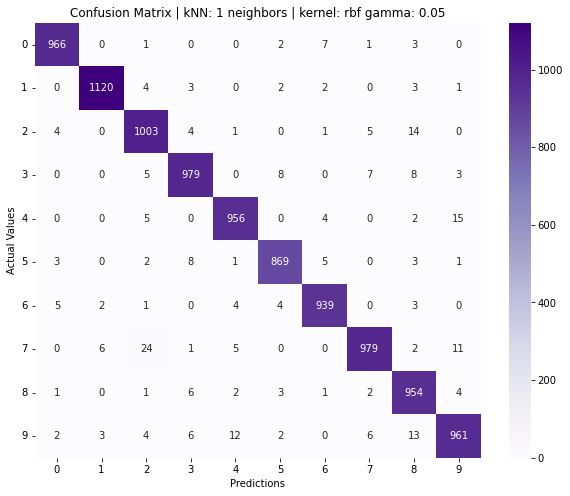

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

label_names = list(range(10))
best_name = " ".join([f'{key}: {val}' for key, val in (params[best_model]).items()])

pred_knn = knn.predict(dist_test)

# fig = plt.figure(figsize=(15,12))
fig = plt.figure()
ax = sns.heatmap(confusion_matrix(y_test, pred_knn), annot=True, cmap='Purples', fmt='g')

ax.set_title(f'Confusion Matrix | kNN: {neighbors[best_n]} neighbors | {best_name}')
ax.set_xlabel('Predictions')
ax.set_ylabel('Actual Values')
# ax.xaxis.set_ticklabels(label_names, rotation=90)
ax.xaxis.set_ticklabels(label_names, rotation=0)
ax.yaxis.set_ticklabels(label_names, rotation=0)

plt.show()
if SAVE_PLOTS:
    save_plots(fig, 'confusion_matrix_knn', FIG_FOLDER)

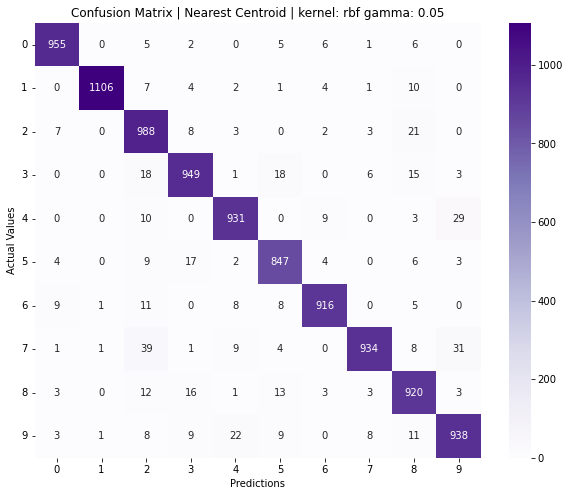

In [21]:
pred_nc = nc.predict(z_test)

# fig = plt.figure(figsize=(15,12))
fig = plt.figure()
ax = sns.heatmap(confusion_matrix(y_test, pred_nc), annot=True, cmap='Purples', fmt='g')

ax.set_title(f'Confusion Matrix | Nearest Centroid | {best_name}')
ax.set_xlabel('Predictions')
ax.set_ylabel('Actual Values')
# ax.xaxis.set_ticklabels(label_names, rotation=90)
ax.xaxis.set_ticklabels(label_names, rotation=0)
ax.yaxis.set_ticklabels(label_names, rotation=0)

plt.show()
if SAVE_PLOTS:
    save_plots(fig, 'confusion_matrix_nc', FIG_FOLDER)

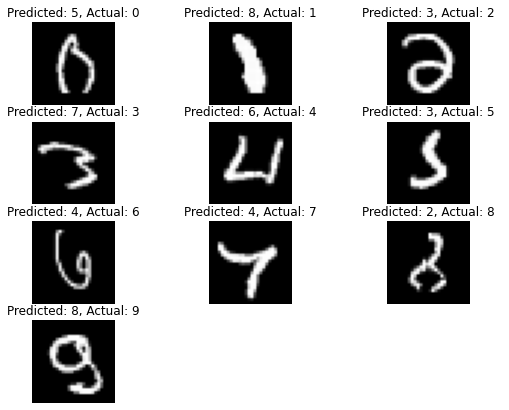

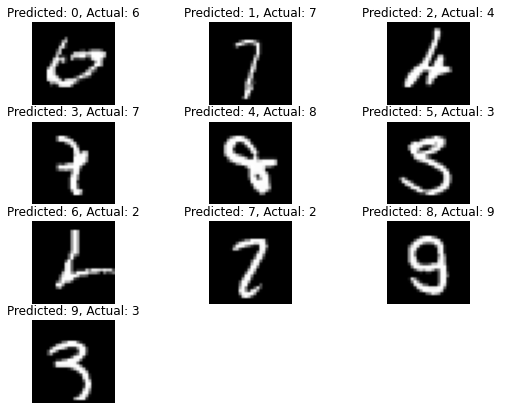

In [22]:
from math import ceil

# print wrong classifications
wrong_classifications = np.where((pred_knn ^ y_test) != 0)[0]
wrong_classes, wrong_idxs = np.unique(y_test[wrong_classifications], return_index=True)

x_test, _ = read_data.load_test_data()

# wrong_images = pipe.inverse_transform(x_test[wrong_classifications[wrong_idxs], :]).reshape(-1,28,28)
wrong_images = x_test[wrong_classifications[wrong_idxs], :]

nrows, ncols = ceil(len(wrong_idxs) / 3), 3
    
fig, ax = plt.subplots(nrows, ncols, figsize=(9,7))
# fig, ax = plt.subplots(nrows, ncols)
for i, image in enumerate(wrong_images):
    ax[i//ncols, i%ncols].imshow(image, cmap='gray', vmin=0, vmax=255)
    ax[i//ncols, i%ncols].set_title(f'Predicted: {pred_knn[wrong_classifications[wrong_idxs[i]]]}, Actual: {y_test[wrong_classifications[wrong_idxs[i]]]}')

# remove all axis
for i in range(nrows):
    for j in range(ncols):
        ax[i,j].axis('off')
plt.show()
if SAVE_PLOTS:
    save_plots(fig, 'wrong_results_knn_1', FIG_FOLDER)

# remove previous images, so we don't display them twice
wrong_classifications = np.delete(wrong_classifications, wrong_idxs)

wrong_classes, wrong_idxs = np.unique(pred_knn[wrong_classifications], return_index=True)
wrong_images = x_test[wrong_classifications[wrong_idxs], :]

nrows, ncols = ceil(len(wrong_idxs) / 3), 3

if nrows > 1:
    fig, ax = plt.subplots(nrows, ncols, figsize=(9,7))
    # fig, ax = plt.subplots(nrows, ncols)
    for i, image in enumerate(wrong_images):
        ax[i//ncols, i%ncols].imshow(image, cmap='gray', vmin=0, vmax=255)
        ax[i//ncols, i%ncols].set_title(f'Predicted: {pred_knn[wrong_classifications[wrong_idxs[i]]]}, Actual: {y_test[wrong_classifications[wrong_idxs[i]]]}')

    # remove all axis
    for i in range(nrows):
        for j in range(ncols):
            ax[i,j].axis('off')
    plt.show()
    if SAVE_PLOTS:
        save_plots(fig, 'wrong_results_knn_2', FIG_FOLDER)

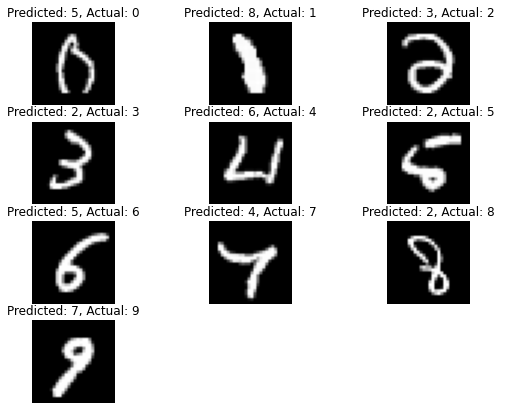

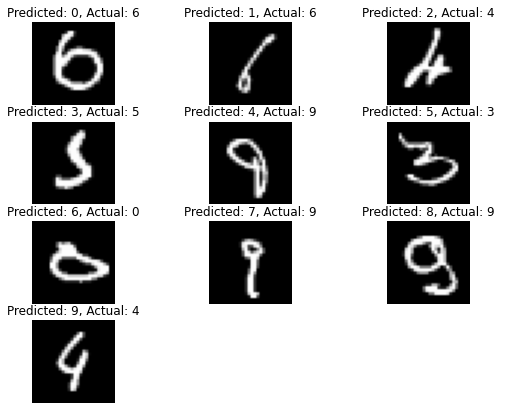

In [23]:
# print wrong classifications
wrong_classifications = np.where((pred_nc ^ y_test) != 0)[0]
wrong_classes, wrong_idxs = np.unique(y_test[wrong_classifications], return_index=True)

x_test, _ = read_data.load_test_data()

# wrong_images = pipe.inverse_transform(x_test[wrong_classifications[wrong_idxs], :]).reshape(-1,28,28)
wrong_images = x_test[wrong_classifications[wrong_idxs], :]

nrows, ncols = ceil(len(wrong_idxs) / 3), 3
    
fig, ax = plt.subplots(nrows, ncols, figsize=(9,7))
# fig, ax = plt.subplots(nrows, ncols)
for i, image in enumerate(wrong_images):
    ax[i//ncols, i%ncols].imshow(image, cmap='gray', vmin=0, vmax=255)
    ax[i//ncols, i%ncols].set_title(f'Predicted: {pred_nc[wrong_classifications[wrong_idxs[i]]]}, Actual: {y_test[wrong_classifications[wrong_idxs[i]]]}')

# remove all axis
for i in range(nrows):
    for j in range(ncols):
        ax[i,j].axis('off')
plt.show()
if SAVE_PLOTS:
    save_plots(fig, 'wrong_results_nc_1', FIG_FOLDER)

# remove previous images, so we don't display them twice
wrong_classifications = np.delete(wrong_classifications, wrong_idxs)

wrong_classes, wrong_idxs = np.unique(pred_nc[wrong_classifications], return_index=True)
wrong_images = x_test[wrong_classifications[wrong_idxs], :]

nrows, ncols = ceil(len(wrong_idxs) / 3), 3

if nrows > 1:
    fig, ax = plt.subplots(nrows, ncols, figsize=(9,7))
    # fig, ax = plt.subplots(nrows, ncols)
    for i, image in enumerate(wrong_images):
        ax[i//ncols, i%ncols].imshow(image, cmap='gray', vmin=0, vmax=255)
        ax[i//ncols, i%ncols].set_title(f'Predicted: {pred_nc[wrong_classifications[wrong_idxs[i]]]}, Actual: {y_test[wrong_classifications[wrong_idxs[i]]]}')

    # remove all axis
    for i in range(nrows):
        for j in range(ncols):
            ax[i,j].axis('off')
    plt.show()
    if SAVE_PLOTS:
        save_plots(fig, 'wrong_results_nc_2', FIG_FOLDER)